In this notebook we evaluate the explainability of two models : KAN and Random Forest, on the UCI classification dataset Adult Income. To do this, we'll be using two popular methods, SHAP and PFI.

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git #Importing the KAN code from github

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-lxz5397r
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-lxz5397r
  Resolved https://github.com/KindXiaoming/pykan.git to commit d51e849bc7e95bc9733d4259e61192ba9bffa697
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78190 sha256=169975178300c157f799d13beb5992ed2e46364a07d36f002da20c3ba38dea4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_hst88qr/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


Import packages

In [ ]:
import torch
from kan import KAN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import shap

Data Analysis ad Cleaning

In [ ]:
df = pd.read_csv("/content/adult.csv")

In [ ]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [ ]:
# Replace "?" with NaN
df.replace("?", pd.NA, inplace=True)
# Drop rows with NaN values
df.dropna(inplace=True)

In [ ]:
distinct_values = df['native-country'].unique()
print("Distinct values in 'State-gov':", distinct_values)

Distinct values in 'State-gov': ['United-States' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India' 'Cambodia'
 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada' 'Portugal'
 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica' 'Ecuador'
 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France' 'Holand-Netherlands']


In [ ]:
# One-hot encoding categorical columns 1/0
columns_encode = ['race', 'gender', 'income']
encoded_data = pd.get_dummies(df[columns_encode], prefix=columns_encode, drop_first=True)
encoded_data = encoded_data.astype(int)

In [ ]:
# Concatenate the one-hot encoded columns with the original DataFrame
df.drop(columns_encode, axis=1, inplace=True)
df = pd.concat([df, encoded_data], axis=1)

In [ ]:
# Encoding categorical features
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']

# Label Encoding for categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,native-country,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male,income_>50K
0,25,2,226802,1,7,4,6,3,0,0,40,38,0,1,0,0,1,0
1,38,2,89814,11,9,2,4,0,0,0,50,38,0,0,0,1,1,0
2,28,1,336951,7,12,2,10,0,0,0,40,38,0,0,0,1,1,1
3,44,2,160323,15,10,2,6,0,7688,0,40,38,0,1,0,0,1,1
5,34,2,198693,0,6,4,7,1,0,0,30,38,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,2,257302,7,12,2,12,5,0,0,38,38,0,0,0,1,0,0
48838,40,2,154374,11,9,2,6,0,0,0,40,38,0,0,0,1,1,1
48839,58,2,151910,11,9,6,0,4,0,0,40,38,0,0,0,1,0,0
48840,22,2,201490,11,9,4,0,3,0,0,20,38,0,0,0,1,1,0


In [ ]:
# Prepare input features and labels
X = df.drop('income_>50K', axis=1)
y = df['income_>50K']

# Ensure X and y do not contain NaNs
X.dropna(inplace=True)
y.dropna(inplace=True)
y = y[X.index]  # Align y with the remaining X

In [ ]:
# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [ ]:
print(X_test.shape)

(6784, 17)


In [ ]:
# Drop NaNs in X_train, X_val, and X_test
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)

In [ ]:
# transforming the data
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [ ]:
# creating the dataset
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

Random Forest Model

In [ ]:
# the best model from GridSearchCV
rf_model = RandomForestClassifier(
    max_depth=10,
    max_samples=0.9,
    min_samples_leaf=4,
    n_estimators=100,
    random_state=1
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions
train_preds_rf = rf_model.predict(X_train)
val_preds_rf = rf_model.predict(X_val)
test_preds_rf = rf_model.predict(X_test)

In [ ]:
#Evaluating the model
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, train_preds_rf))
print("Validation Accuracy:", accuracy_score(y_val, val_preds_rf))
print("Test Accuracy:", accuracy_score(y_test, test_preds_rf))

# Precision, rappel, F1-score
print("Train Precision:", precision_score(y_train, train_preds_rf))
print("Train Recall:", recall_score(y_train, train_preds_rf))
print("Train F1-Score:", f1_score(y_train, train_preds_rf))

Train Accuracy: 0.8639393460748697
Validation Accuracy: 0.8487394957983193
Test Accuracy: 0.8517099056603774
Train Precision: 0.8218518518518518
Train Recall: 0.5702171399203392
Train F1-Score: 0.6732913600849579


PFI for Random Forest

Ordered Feature Importance (PFI):
                    Feature  Importance   Std Dev
8              capital-gain    0.042615  0.001424
4           educational-num    0.037972  0.002519
7              relationship    0.027358  0.002085
9              capital-loss    0.009802  0.001098
0                       age    0.008535  0.001839
5            marital-status    0.007046  0.001373
10           hours-per-week    0.006736  0.001071
3                 education    0.001828  0.000679
16              gender_Male    0.001710  0.000902
2                    fnlwgt    0.001400  0.000702
6                occupation    0.000988  0.000571
1                 workclass    0.000236  0.000494
15               race_White    0.000206  0.000296
12  race_Asian-Pac-Islander    0.000147  0.000000
11           native-country    0.000088  0.000240
14               race_Other    0.000000  0.000000
13               race_Black   -0.000339  0.000209


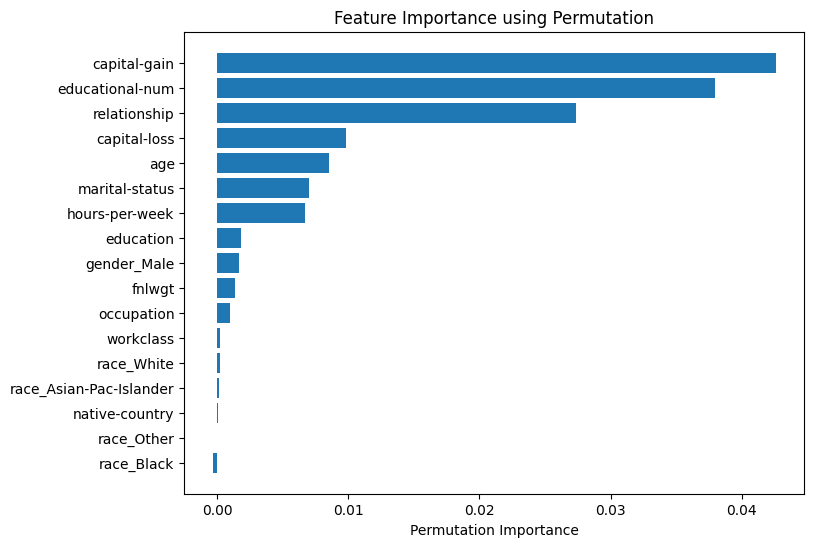

In [ ]:
# Calculate Permutation Feature Importance (PFI)
pfi_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Create a DataFrame to store the importance results
pfi_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean,
    'Std Dev': pfi_result.importances_std
})

# Sort the features by importance
pfi_importances_sorted = pfi_importances.sort_values(by='Importance', ascending=False)

# Display the ordered feature importances
print("Ordered Feature Importance (PFI):")
print(pfi_importances_sorted)

# Plot the feature importance in descending order
plt.figure(figsize=(8, 6))
plt.barh(pfi_importances_sorted['Feature'], pfi_importances_sorted['Importance'])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance using Permutation")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

SHAP for Random Forest

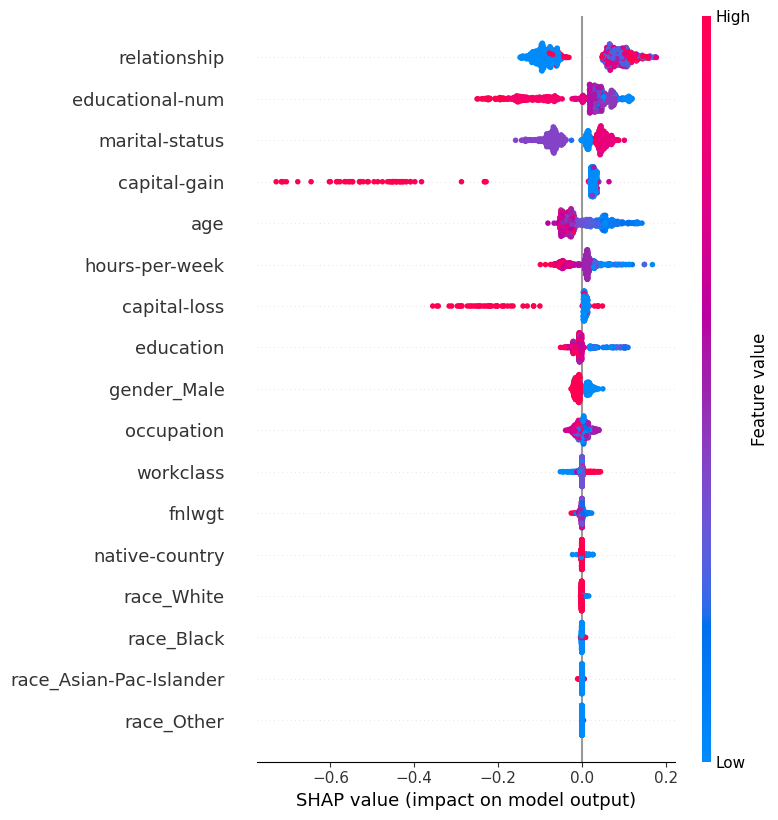

In [ ]:
# Initialize SHAP explainer for the Random Forest model
X_test_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer(X_test_sample)
shap.summary_plot(shap_values_rf[:,:,0], X_test_sample)

# Calculate the mean absolute SHAP value for each feature across all samples for class 0
shap_importances = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Importance': np.mean(np.abs(shap_values_rf[:,:,0].values), axis=0) # Calculate mean absolute SHAP value for each feature
})
shap_importances_sorted = shap_importances.sort_values(by='Importance', ascending=False)

Agreement metric

In [ ]:
# Function to measure greement for the top k features using Jaccard Index
def agreement_metric(top_k_shap, top_k_pfi):
    set_shap = set(top_k_shap)
    set_pfi = set(top_k_pfi)

    intersection = len(set_shap.intersection(set_pfi))
    union = len(set_shap.union(set_pfi))

    score = intersection / union if union != 0 else 0
    return score

In [ ]:
# Define k the number of top features to compare
k = 4

# Extract top k features
top_k_shap = shap_importances_sorted['Feature'][:k]
top_k_pfi = pfi_importances_sorted['Feature'][:k]

score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score:.4f}")


Agreement metric for the top 4 features using Random Forest: 0.6000


KAN Model

In [ ]:
# Create the KAN model
model = KAN(width=[17, 8, 1], grid=5, k=3, seed=0)  # one hidden layer with 8 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
results = model.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.BCEWithLogitsLoss() #Binary crossentropy loss
)

| train_loss: 7.07e-01 | test_loss: 8.49e-01 | reg: 2.39e+01 | : 100%|█| 50/50 [12:17<00:00, 14.74s/

saving model version 0.1


In [ ]:

# Predictions of train, val, and test datasets
test_preds = model.forward(test_input).detach()
train_preds = model.forward(train_input).detach()
val_preds = model.forward(val_input).detach()

# Sigmoid to get probabilities
test_probs = torch.sigmoid(test_preds)
train_probs = torch.sigmoid(train_preds)
val_probs = torch.sigmoid(val_preds)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
test_preds_binary = (test_probs >= 0.5).int()
train_preds_binary = (train_probs >= 0.5).int()
val_preds_binary = (val_probs >= 0.5).int()

# Evaluate metrics for training data
train_labels = train_label.numpy()
train_preds_binary = train_preds_binary.numpy()
val_labels = val_label.numpy()
val_preds_binary = val_preds_binary.numpy()
test_labels = test_label.numpy()
test_preds_binary = test_preds_binary.numpy()

print("Train Accuracy:", accuracy_score(train_labels, train_preds_binary))
print("Train Precision:", precision_score(train_labels, train_preds_binary))
print("Val Accuracy:", accuracy_score(val_labels, val_preds_binary))
print("Val Precision:", precision_score(val_labels, val_preds_binary))
print("Test Accuracy:", accuracy_score(test_labels, test_preds_binary))
print("Test Precision:", precision_score(test_labels, test_preds_binary))



Train Accuracy: 0.7729584583794029
Train Precision: 0.982200647249191
Val Accuracy: 0.7561550936163939
Val Precision: 0.9622641509433962
Test Accuracy: 0.7675412735849056
Test Precision: 0.9444444444444444


In [ ]:
# Create the KAN model
model3 = KAN(width=[17, 8, 4, 1], grid=8, k=3, seed=0)  # one hidden layer with 8 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
results3 = model3.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.BCEWithLogitsLoss() #Binary crossentropy loss
)

| train_loss: 7.24e-01 | test_loss: 7.40e-01 | reg: 3.12e+01 | : 100%|█| 50/50 [11:03<00:00, 13.28s/

saving model version 0.1


In [ ]:
# Predictions of train, val, and test datasets
test_preds = model3.forward(test_input).detach()
train_preds = model3.forward(train_input).detach()
val_preds = model3.forward(val_input).detach()

# Sigmoid to get probabilities
test_probs = torch.sigmoid(test_preds)
train_probs = torch.sigmoid(train_preds)
val_probs = torch.sigmoid(val_preds)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
test_preds_binary = (test_probs >= 0.5).int()
train_preds_binary = (train_probs >= 0.5).int()
val_preds_binary = (val_probs >= 0.5).int()

# Evaluate metrics for training data
train_labels = train_label.numpy()
train_preds_binary = train_preds_binary.numpy()
val_labels = val_label.numpy()
val_preds_binary = val_preds_binary.numpy()
test_labels = test_label.numpy()
test_preds_binary = test_preds_binary.numpy()

print("Train Accuracy:", accuracy_score(train_labels, train_preds_binary))
print("Train Precision:", precision_score(train_labels, train_preds_binary))
print("Val Accuracy:", accuracy_score(val_labels, val_preds_binary))
print("Val Precision:", precision_score(val_labels, val_preds_binary))
print("Test Accuracy:", accuracy_score(test_labels, test_preds_binary))
print("Test Precision:", precision_score(test_labels, test_preds_binary))


Train Accuracy: 0.7939661980729743
Train Precision: 0.7034527266860278
Val Accuracy: 0.7756155093616394
Val Precision: 0.6780185758513931
Test Accuracy: 0.7858195754716981
Test Precision: 0.6724137931034483


Best KAN Model

In [ ]:
# Create the KAN model
model4 = KAN(width=[17, 8, 8, 1], grid=8, k=3, seed=0)  # two hidden layers with 8 neurons each

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
results4 = model4.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.BCEWithLogitsLoss() #Binary crossentropy loss
)

| train_loss: 7.01e-01 | test_loss: 7.18e-01 | reg: 2.80e+01 | : 100%|█| 50/50 [10:16<00:00, 12.33s/

saving model version 0.1


In [ ]:
# Predictions of train, val, and test datasets
test_preds = model4.forward(test_input).detach()
train_preds = model4.forward(train_input).detach()
val_preds = model4.forward(val_input).detach()

# Sigmoid to get probabilities
test_probs = torch.sigmoid(test_preds)
train_probs = torch.sigmoid(train_preds)
val_probs = torch.sigmoid(val_preds)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
test_preds_binary = (test_probs >= 0.5).int()
train_preds_binary = (train_probs >= 0.5).int()
val_preds_binary = (val_probs >= 0.5).int()

# Evaluate metrics for training data
train_labels = train_label.numpy()
train_preds_binary = train_preds_binary.numpy()
val_labels = val_label.numpy()
val_preds_binary = val_preds_binary.numpy()
test_labels = test_label.numpy()
test_preds_binary = test_preds_binary.numpy()

print("Train Accuracy:", accuracy_score(train_labels, train_preds_binary))
print("Train Precision:", precision_score(train_labels, train_preds_binary))
print("Val Accuracy:", accuracy_score(val_labels, val_preds_binary))
print("Val Precision:", precision_score(val_labels, val_preds_binary))
print("Test Accuracy:", accuracy_score(test_labels, test_preds_binary))
print("Test Precision:", precision_score(test_labels, test_preds_binary))


Train Accuracy: 0.8001579529300269
Train Precision: 0.7567853366231935
Val Accuracy: 0.7819548872180451
Val Precision: 0.7309644670050761
Test Accuracy: 0.7914209905660378
Test Precision: 0.7193877551020408


PFI for KAN

                   Features   Importances
8              capital-gain  6.306354e-02
9              capital-loss  2.238243e-02
2                    fnlwgt  7.253428e-04
0                       age  1.665930e-04
10           hours-per-week  1.400560e-04
4           educational-num  8.845644e-05
3                 education  6.191950e-05
5            marital-status  4.717677e-05
1                 workclass  2.801120e-05
7              relationship  2.063983e-05
11           native-country  1.031992e-05
6                occupation -3.330669e-16
12  race_Asian-Pac-Islander -3.330669e-16
13               race_Black -3.330669e-16
14               race_Other -3.330669e-16
15               race_White -3.330669e-16
16              gender_Male -3.330669e-16


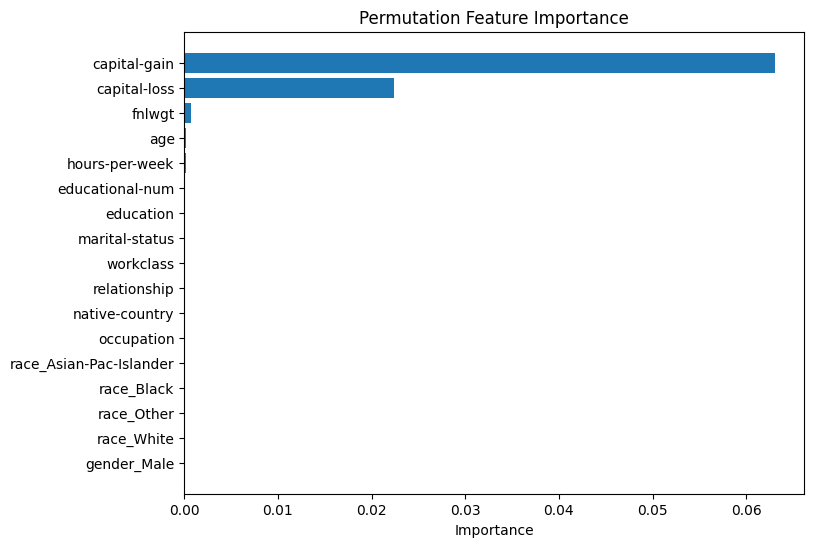

In [ ]:

# Function to evaluate model performance using accuracy
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32))
        probs = torch.sigmoid(logits).numpy()
        predictions = (probs >= 0.5).astype(int)
    return accuracy_score(y, predictions)

# Function to calculate permutation feature importance (PFI)
def permutation_importance(model, X, y, metric=evaluate_model, n_repeats=100):
    baseline_score = metric(model, X, y)
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(model, X_permuted, y)
            scores.append(score)
        importances[i] = baseline_score - np.mean(scores)

    return importances


# Convert validation data to numpy arrays
X_val_tensor = X_val.to_numpy()
y_val_tensor = y_val.to_numpy()

# Calculate feature importances
importances_kan = permutation_importance(model4, X_val_tensor, y_val_tensor)

# Create DataFrame with feature importances
importance_df = pd.DataFrame({
    'Features': X_val.columns,
    'Importances': importances_kan
}).sort_values(by='Importances', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Features'], importance_df['Importances'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


SHAP for KAN

In [ ]:

# Define a prediction function that returns probabilities
def predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        # Get logits from the model and apply sigmoid to get probabilities
        logits = model4(data_tensor)
        probs = torch.sigmoid(logits).numpy()
    return probs

# Sampling data
X_train_subset = X_train.sample(100, random_state=42).to_numpy()
X_test_subset = X_test.sample(100, random_state=42).to_numpy()

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(predict, X_train_subset)

# Compute SHAP values for the test set subset
shap_values = explainer.shap_values(X_test_subset)

if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Select the SHAP values for class 1 (positive class)

# Plot the SHAP summary plot to visualize feature importance
shap_values = np.squeeze(shap_values)

# Convert the SHAP values into a DataFrame
shap_importances_kan = pd.DataFrame(shap_values, columns=X_test.columns)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  output_range_spline = torch.std(postacts_numerical, dim

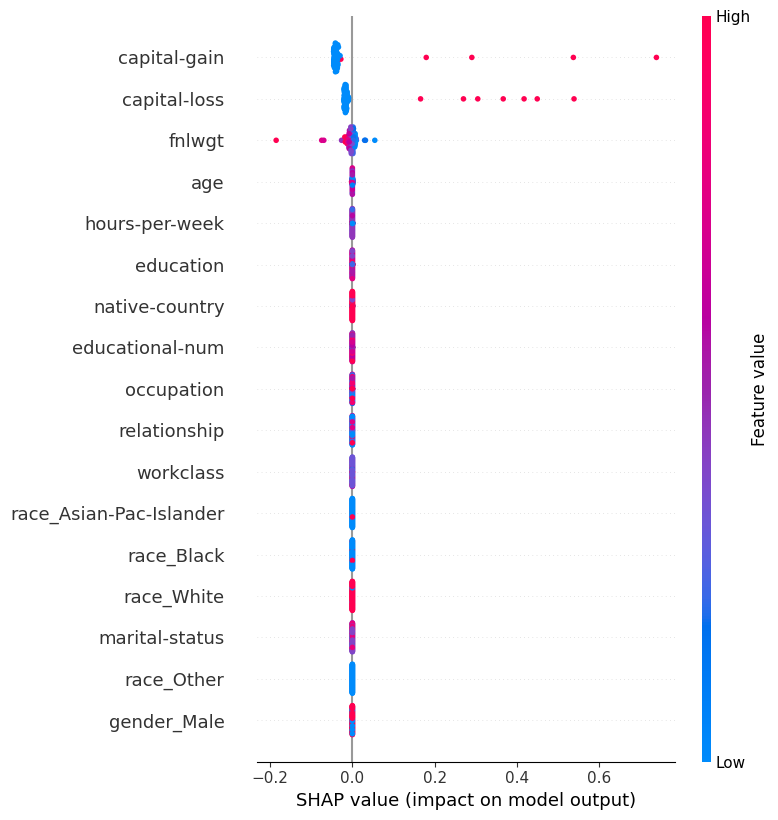

In [ ]:
shap.summary_plot(shap_values, X_test_subset, feature_names=X_test.columns)

Agreement metric

In [ ]:
# Calculate the absolute SHAP values to evaluate feature importance
shap_abs_values = np.abs(shap_values)
# Define k the number of top features to compare
k = 4
# Calculate the mean absolute SHAP values for each feature
feature_importances = np.mean(shap_abs_values, axis=0)
top_k_indices = np.argsort(feature_importances)[-k:]

# Extract top k features
top_k_shap = X_test.columns[top_k_indices]
top_k_pfi = importance_df['Features'][:k]

# Compute the Jaccard Index for the top k features
score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score:.4f}")

Agreement metric for the top 4 features using Random Forest: 1.0000
